In [2]:
!pip install geopandas rasterio rioxarray torchmetrics

  Using cached geopandas-0.14.0-py3-none-any.whl (1.1 MB)
  Using cached rasterio-1.3.8.post2-cp310-cp310-manylinux2014_x86_64.whl (20.6 MB)
  Using cached rioxarray-0.15.0-py3-none-any.whl (53 kB)
  Using cached torchmetrics-1.2.0-py3-none-any.whl (805 kB)
  Using cached fiona-1.9.5-cp310-cp310-manylinux2014_x86_64.whl (15.7 MB)
  Using cached pyproj-3.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached shapely-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached xarray-2023.9.0-py3-none-any.whl (1.0 MB)
  Using cached lightning_utilities-0.9.0-py3-none-any.whl (23 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import rioxarray
import pickle

# for torch
import tempfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import detect_anomaly
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def crop_images(year: int,
                mesh_num: int,
                key_id: int,
                gdf,
                mesh_dir='../data/census/mesh',
                land_dir='../data/Landsat',
                ntl_dir ='../data/VIIRS/GeoTiff',
                all_dir ='../data/all_combined',
                size=224,
                mode=None
               ):
    """
    A function of cropping images with the extent of mesh.

    Args:
    year               : An integer indicating the mesh of census boundary.
    mesh_num           : An integer indicating the number of mesh extent.
    key_id             : An integer indicating the id of mesh cell.
    gdf                : An GeoDataDrame object which contains vector data of aggregated mesh and demographics.
    mesh_dir           : The directory of mesh boundary. By default, it is '../data/census/mesh'.
    land_dir           : The directory of landsat images. By default, it is '../data/Landsat'.
    ntl_dir            : The directory of VIIRS images. By default, it is '../data/VIIRS/GeoTiff'.
    all_dir            : The directory of final output. By default, it is '../data/all_combined'.
    size               : An integer of final output pixel size. By default, it is 224.
    mode               : An string indicating either 'save' or 'return' the output.

    Returns:
        stacked_layers : A np.ndarray object of stacked layers from Landsat-8 and VIIRS.
    """

    # obtain the geometry of mesh cell
    try:
        key_code = gdf.iloc[key_id]['KEY_CODE']
        geom = [gdf.geometry[key_id]]
    except:
        key_code = gdf['KEY_CODE']
        geom = [gdf.geometry]

    # create 'tmp' directory if it does not exist
    if not os.path.exists(os.path.join(all_dir, 'tmp')):
        os.mkdir(os.path.join(all_dir, 'tmp'))

    # crop Landsat-8 (Daytime image)
    with rasterio.open(os.path.join(land_dir, str(year), str(mesh_num)+'.tif')) as img_lands:
        lands_cropped, lands_transf = mask(img_lands, geom, crop=True, all_touched=True)
        lands_meta = img_lands.meta

    # update the metadata
    lands_meta.update({"driver": "GTiff",
                       "height": lands_cropped.shape[1],
                       "width": lands_cropped.shape[2],
                       "transform": lands_transf})

    # store the cropped Landsat-8/OLI
    with rasterio.open(os.path.join(all_dir, 'tmp', str(key_code) + '_landsat.tif'), "w", **lands_meta) as dest:
        dest.write(lands_cropped)

    # crop Suomi NPP/VIIRS-DNS
    with rasterio.open(os.path.join(ntl_dir, 'processed', str(year), str(year)+'.tif')) as img_viirs:
        viirs_cropped, viirs_transf = mask(img_viirs, geom, crop=True, all_touched=True)
        viirs_meta = img_viirs.meta

    # update the metadata
    viirs_meta.update({"driver": "GTiff",
                       "height": viirs_cropped.shape[1],
                       "width": viirs_cropped.shape[2],
                       "transform": viirs_transf})

    # store the cropped Suomi NPP/VIIRS-DNS
    with rasterio.open(os.path.join(all_dir, 'tmp', str(key_code) + '_viirs.tif'), "w", **viirs_meta) as dest:
        dest.write(viirs_cropped)

    # open the cropped GeoTIFF files
    xds_lands = rioxarray.open_rasterio(os.path.join(all_dir, 'tmp', str(key_code) + '_landsat.tif'))
    xds_viirs = rioxarray.open_rasterio(os.path.join(all_dir, 'tmp', str(key_code) + '_viirs.tif'))

    # reproject the Suomi NPP/VIIRS-DNS to Landsat-8/OLI for adjusting resolution
    xds_viirs = xds_viirs.rio.reproject_match(xds_lands)

    # resize pixels
    xds_viirs = xds_viirs.rio.reproject('EPSG:4326', shape=(size,size))
    xds_lands = xds_lands.rio.reproject('EPSG:4326', shape=(size,size))

    if mode == 'save':
        # save the reprojected VIIRS into GeoTIFF file
        xds_lands.rio.to_raster(os.path.join(all_dir, 'tmp', str(key_code) + '_landsat.tif'))
        xds_viirs.rio.to_raster(os.path.join(all_dir, 'tmp', str(key_code) + '_viirs.tif'))

    elif mode == 'return':
        # stack the layers into a single np.ndarray object
        stacked_layers = np.vstack([xds_lands.values, xds_viirs.values])

        # delete tmp files
        os.remove(os.path.join(all_dir, 'tmp', str(key_code) + '_landsat.tif'))
        os.remove(os.path.join(all_dir, 'tmp', str(key_code) + '_viirs.tif'))

        return stacked_layers

In [5]:
def append_index_layers(image: np.ndarray):
    """
    A function of appending layers of three indices (NDWI, NDBI, NDVI).

    Args:
        image: A np.ndarray object containing 7 layers of Landsat-8 and 1 layer of Suomi NPP.

    Returns:
        image: A np.ndarray object which additionally contains index layers
    """

    # check whether the image has proper number of layers or not
    assert image.shape[0] == 8

    # store relevant bands
    band_3 = image[2,:,:]
    band_4 = image[3,:,:]
    band_5 = image[4,:,:]
    band_6 = image[5,:,:]

    # calculate indices
    NDBI = (band_6 - band_5) / (band_6 + band_5)
    NDVI = (band_5 - band_4) / (band_5 + band_4)
    NDWI = (band_3 - band_5) / (band_3 + band_5)

    # stack index layers
    index_layers = np.stack([NDBI,NDVI,NDWI],axis=0)

    # append index layers to the original image
    image = np.vstack([image,index_layers])

    return image

In [6]:
def set_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    return device

In [7]:
class RemoteSensingDataset(Dataset):

    def __init__(self, master_gdf, size=224, labels=True):
        self.master_gdf = master_gdf
        self.size = size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if self.device.type == "cpu":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
            
        self.labels = labels

    def __len__(self):
        return len(self.master_gdf)

    def __getitem__(self, idx):

        # obtain the target labeled mesh cell
        gdf = self.master_gdf.iloc[idx]

        # get year and key_id
        year = gdf['year']
        mesh_num = gdf['MESH1_ID']
        key_id = gdf['KEY_CODE']

        # crop the image with the extent of labeled mesh cell and convert them into tensor
        image = crop_images(year=year, mesh_num=mesh_num, key_id=key_id, gdf=gdf, size=self.size, mode='return')
        image = append_index_layers(image)
        image = torch.tensor(image, requires_grad=True).to(self.device)

        if self.labels:
            # log based on 10 and convert them into tensor
            label = gdf[['0_14', '15_64', 'over_64']]
            label = [math.log10(value +1e-7) for value in label]
            label = np.maximum(label, 0)
            label = torch.tensor(label, requires_grad=True).float().to(self.device)
            return image, label

        else:
            return image

In [8]:
class RemoteSensingCNN(nn.Module):
    """
    A class of CNN model with transfer learning from ResNet50.
    """

    def __init__(self, out_dim, pretrained):
        super(RemoteSensingCNN, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if self.device.type == "cpu":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        self.conv_band2_4 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.conv_band5_7 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        self.bn_band2_4 = nn.BatchNorm2d(64)
        self.bn_band5_7 = nn.BatchNorm2d(64)
        self.conv_all = nn.Conv2d(
            in_channels=64 + 64, out_channels=64, kernel_size=1, bias=False
        )
        self.resnet = models.resnet50(pretrained=pretrained).to(self.device)
        self.fc2 = nn.Linear(1000, out_dim)
        self.dropout = nn.Dropout(0.25)

        self.conv_band2_4.load_state_dict(self.resnet.conv1.state_dict())
        self.conv_band5_7.load_state_dict(self.resnet.conv1.state_dict())

    def forward(self, x):
        band2_4 = x[:, 2 - 1 : 4, :, :].flip(dims=[0])
        band5_7 = x[:, 5 - 1 : 7, :, :].flip(dims=[0])

        band2_4 = self.conv_band2_4(band2_4)
        band5_7 = self.conv_band5_7(band5_7)

        band2_4 = F.relu(self.bn_band2_4(band2_4))
        band5_7 = F.relu(self.bn_band5_7(band5_7))

        x = torch.cat((band2_4, band5_7), dim=1)
        x = self.conv_all(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.resnet.fc(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

In [9]:
def train(model,
          train_loader: torch.utils.data.dataloader.DataLoader,
          valid_loader: torch.utils.data.dataloader.DataLoader,
          epochs: int,
          early_stopping: int,
          record_path='../src/pretrained/record_dict_pkl',
          latest_path='../src/pretrained/latest_model',
          best_path='../src/pretrained/best_model'):
    """
    A function of managing the training of CNN model at once.

    Args:
       model           : An object of RemoteSensingCNN.
       train_loader    : A torch.utils.data.dataloader.DataLoader object for training dataset.
       valid_loader    : A torch.utils.data.dataloader.DataLoader object for validation dataset.
       epochs          : An integer which specifies the number of total epoches.
       early_stopping  : An integer which spcefifies the torrelance of early stopping.
       record_path     : By default, it is '../src/pretrained/record_dict_pkl'.
       latest_path     : By default, it is '../src/pretrained/latest_model'.
       best_path       : By default, it is '../src/pretrained/best_model'.

    Returns:
        None
    """

    # store a string of availability of GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # if there is already a recorded file, import it together with the latest model
    if os.path.exists(record_path):
        with open(record_path, 'rb') as f:
            record_dict = pickle.load(f)
        best_loss = min([v['valid_loss'] for v in record_dict.values()])
        model.load_state_dict(torch.load(latest_path, map_location=torch.device(device)))

    # initiate the record dictornary and best loss as positive infinite
    else:
        record_dict = {}
        best_loss = np.inf

    # initialise a loss function object (MSE)
    #criterion = nn.MSELoss()
    
    # initialise a loss functio object (Huber loss)
    criterion = nn.HuberLoss()

    # initialise an optimiser object (Adam)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # set CPU or GPU
    model = model.to(device)

    # initialise a variable for early stopping
    not_improving = 0

    # iterate over epochs
    for epoch in range(epochs):

        # set seed by epoch
        torch.manual_seed(epoch)

        # skip completed epoches 
        if epoch in record_dict.keys():
            continue

        # change mode as training
        model.train(True)

        # initialise a list for training loss
        train_loss = []

        for i, (img, label) in enumerate(train_loader):

            with detect_anomaly():

                # convert images and labels to either CPU tensor or GPU tensor
                img, label = img.to(device), label.to(device)

                # clean up the gradient
                optimizer.zero_grad()

                # execute forward propagation
                output = model(img)

                # if the output is NaN, skip back propagation
                if torch.isnan(output).any():
                    print(f'[epoch {epoch + 1},{i + 1:3d}] loss: skipped due to nan')

                else:
                    # calculate RMSE of logged labels
                    #loss = torch.sqrt(criterion(label, output))
                    
                    # calculate log cosh
                    loss = criterion(label, output)

                    # execute back propagation
                    loss.backward()
                    optimizer.step()

                    # store the training loss of this iteration
                    train_loss.append(loss.item())

                    print(f'[epoch {epoch + 1},{i + 1:3d}] loss: {loss.item():.3f}')

        # calculate mean of the training loss
        train_loss = np.mean(train_loss)

        # release memory on GPU
        if device == 'cuda:0' or device.type == "mps":
            gc.collect()
            torch.cuda.empty_cache()

        # change mode as validation
        model.eval()

        # initialise a list for validation loss
        valid_loss = []
        with torch.no_grad():
            for i, (img, label) in enumerate(valid_loader):
                with detect_anomaly():

                    # convert images and labels to either CPU tensor or GPU tensor
                    img, label = img.to(device), label.to(device)

                    # execute forward propagation
                    output = model(img)

                    # calculate RMSE of logged labels
                    #loss = torch.sqrt(criterion(label, output))

                    # calculate Huber loss
                    loss = criterion(label, output)                

                    # store the validation loss of this iteration
                    valid_loss.append(loss.item())

        # calculate mean of the validation loss
        valid_loss = np.mean(valid_loss)

        # if the validation loss is the best so far, store it as best_loss and save the model
        if valid_loss < best_loss:
            best_loss  = valid_loss
            torch.save(model.state_dict(), best_path)
            not_improving = 0
        else:
            not_improving += 1

        # update the record dictionary
        record_dict.update({epoch:
                            {'train_loss': train_loss,
                             'valid_loss': valid_loss}})

        print(f'[epoch {epoch + 1}] train_loss: {train_loss:.3f}, valid_loss: {valid_loss:.3f}')

        # save record_dict as pickle
        with open(record_path, 'wb') as f:
            pickle.dump(record_dict, f)

        # save the latest model
        torch.save(model.state_dict(), latest_path)

        if not_improving == early_stopping:
            print("Early Stopping...")
            break

In [ ]:
# Band 432 + Band 765 + Index + NTL (not pretrained)

master_gdf = gpd.read_file('../data/census/master_gdf.gpkg')

remote_sensing_cnn = RemoteSensingCNN(out_dim=3, pretrained=False)

key_codes = master_gdf[['0_14', '15_64', 'over_64', 'KEY_CODE']].groupby('KEY_CODE').mean().sum(axis=1)
key_deciles = pd.qcut(key_codes, 10, labels=False)

train_key_codes, valid_key_codes = train_test_split(key_deciles, test_size=.2, random_state=1, stratify=key_deciles)
valid_key_codes, test_key_codes = train_test_split(valid_key_codes, test_size=.5, random_state=1, stratify=valid_key_codes)

train_gdf = master_gdf[master_gdf['KEY_CODE'].isin(train_key_codes.index)]
valid_gdf = master_gdf[master_gdf['KEY_CODE'].isin(valid_key_codes.index)]
test_gdf = master_gdf[master_gdf['KEY_CODE'].isin(test_key_codes.index)]

train_dataset = RemoteSensingDataset(train_gdf, size=334)
valid_dataset = RemoteSensingDataset(valid_gdf, size=334)
test_dataset  = RemoteSensingDataset(test_gdf, size=334)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

train(remote_sensing_cnn,
      train_loader,
      valid_loader,
      epochs=3,
      early_stopping=30,
      record_path='../models/432_765/record_dict_pkl',
      latest_path='../models/432_765/latest_model',
      best_path='../models/432_765/best_model')

[epoch 1,  1] loss: 1.980
[epoch 1,  2] loss: 3.818
[epoch 1,  3] loss: 1.987
[epoch 1,  4] loss: 1.077
[epoch 1,  5] loss: 0.804
[epoch 1,  6] loss: 0.602
[epoch 1,  7] loss: 0.549
[epoch 1,  8] loss: 0.648
[epoch 1,  9] loss: 1.185
[epoch 1, 10] loss: 0.906
[epoch 1, 11] loss: 0.886
[epoch 1, 12] loss: 0.630
[epoch 1, 13] loss: 0.727
[epoch 1, 14] loss: 0.469
[epoch 1, 15] loss: 0.508
[epoch 1, 16] loss: 0.442
[epoch 1, 17] loss: 0.622
[epoch 1, 18] loss: 0.596
[epoch 1, 19] loss: 0.643
[epoch 1, 20] loss: 0.495
[epoch 1, 21] loss: 0.728
[epoch 1, 22] loss: 0.805
[epoch 1, 23] loss: 0.676
[epoch 1, 24] loss: 0.512
[epoch 1, 25] loss: 0.724
[epoch 1, 26] loss: 0.665
[epoch 1, 27] loss: 0.501
[epoch 1, 28] loss: 0.489
[epoch 1, 29] loss: 0.657
[epoch 1, 30] loss: 0.655
[epoch 1, 31] loss: 0.780
[epoch 1, 32] loss: 0.573
[epoch 1, 33] loss: 0.551
[epoch 1, 34] loss: 0.611
[epoch 1, 35] loss: 0.607
[epoch 1, 36] loss: 0.478
[epoch 1, 37] loss: 0.652
[epoch 1, 38] loss: 0.559
[epoch 1, 39

<h2 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
5. Result
</h2>

<h3 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
<i>Result of training and validation</i>
</h3>

In [3]:
with open('../src/pretrained/outputs.pth', 'rb') as p:
    outputs = pickle.load(p)

test_loss = 0.3214581294192208

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
As a result of the training and validation process, Figure 11 illustrates the training and validation loss function over 250 epochs. In the early epochs, the validation loss function had a volatility of up to 1.22. While the training loss was steadily decreased throughout the epochs, validation loss reached its lower bound of 0.35 at around the epoch 50 and little improvement was observed in the following epochs. The training loss recorded 0.3186 as the minima at epoch 238, and the model at the epoch was employed as the one with the most generalisability for the testing and dataset generation.
</div>

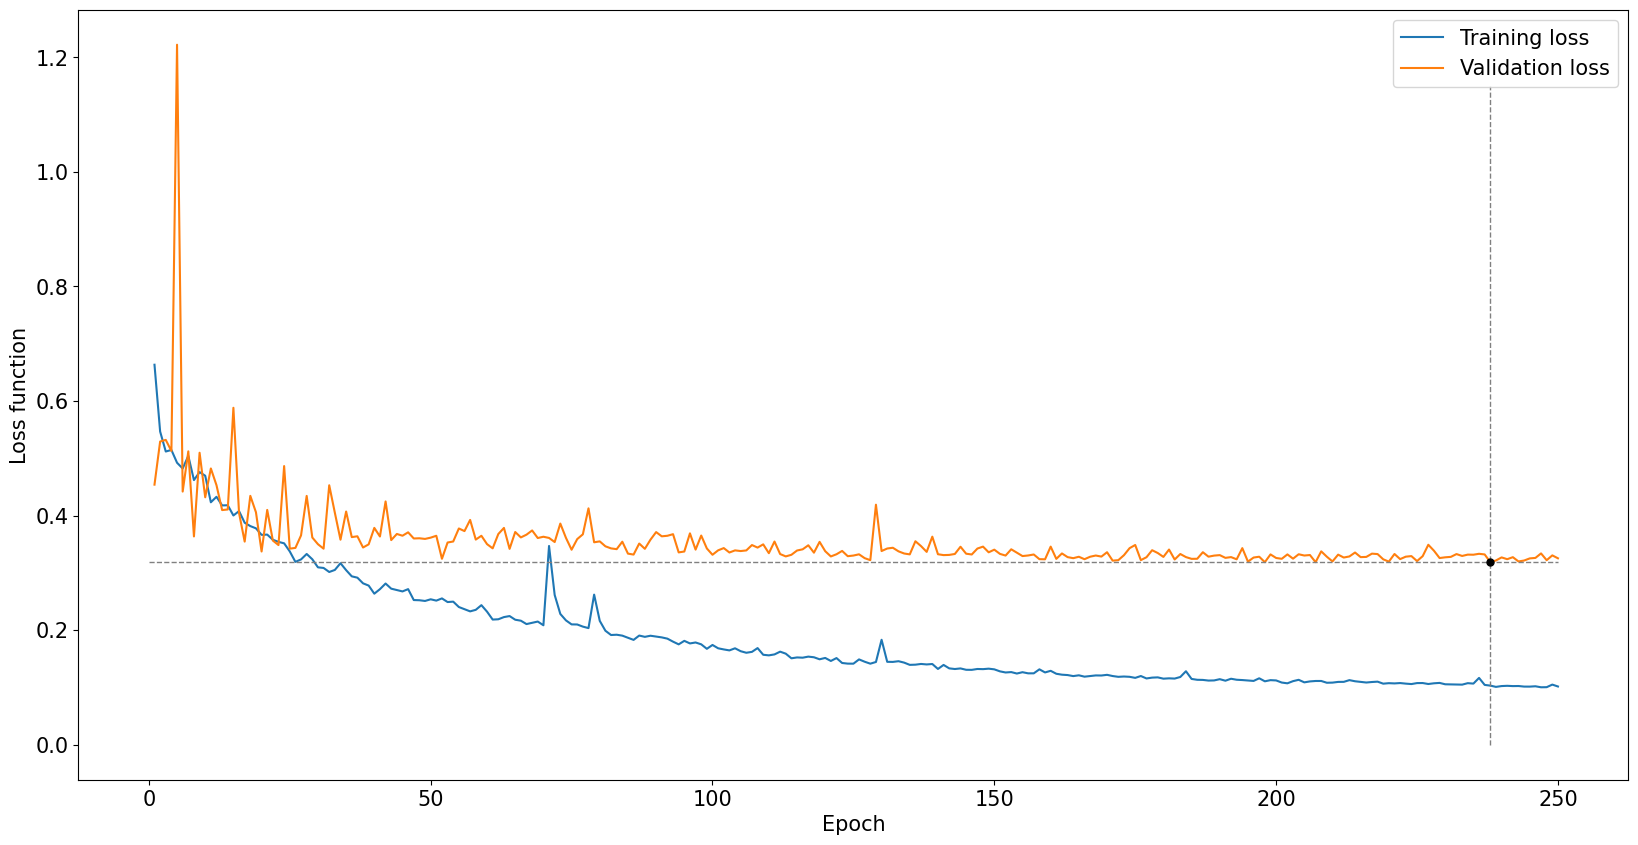

In [319]:
with open('../src/pretrained/record_dict_pkl', 'rb') as f:
    record_dict = pickle.load(f)

records = pd.DataFrame(record_dict).transpose()

plt.rcParams.update({'font.size': 15})
plt.rc('legend', fontsize=15)

fig, ax = plt.subplots(figsize=(20,10))

ax.plot([i+1 for i in records.index], records['train_loss'])
ax.plot([i+1 for i in records.index], records['valid_loss'])

ax.vlines(np.argmin(records['valid_loss'])+1,0,1.15, linestyle="dashed", color='grey', linewidth=1)
ax.hlines(np.min(records['valid_loss']),0,250, linestyle="dashed", color='grey', linewidth=1)
ax.plot(np.argmin(records['valid_loss'])+1,np.min(records['valid_loss']), '.' ,markersize=10, color='black')

ax.legend(['Training loss', 'Validation loss'])

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss function")

plt.show()

<div style='text-align: center; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
<b>Figure 11.</b> Training and validation progress of the CNN model. The grey horizontal and vertical dotted lines indicate the lowest value of the loss function in the validation dataset throughout the epochs and its epoch, respectively. The intersection of the dotted lines indicate the loss function of the validation dataset at epoch 238.
</div>

In [356]:
print("The best validation score was recorded by the model with loss function of {:.4f} at epoch {}."
      .format(np.min(records['valid_loss']),
              np.argmin(records['valid_loss'])+1))

print("The loss function in the training dataset was {:.4f} at epoch {}."
      .format(records.iloc[np.argmin(records['valid_loss']), 0],
              np.argmin(records['valid_loss'])+1))

The best validation score was recorded by the model with loss function of 0.3186 at epoch 238.
The loss function in the training dataset was 0.1032 at epoch 238.


<h3 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
<i>Result of testing</i>
</h3>

In [23]:
test_gdf = gpd.read_file('../data/census/test_gdf.gpkg')

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
With the trained model chosen above, the testing dataset was utilised for calculating the testing score in $R^2_{(G)}$, as well as the loss function. To do so, all the images in the testing dataset were passed through the CNN model as forward propagation, and outputs were used for calculating loss function as test error. The outputs were stored in an object "outputs". As a result, the test error was 0.3215, which was close to the one in the validation dataset.</div>

In [580]:
# create an instance of a CNN model
remote_sensing_cnn = RemoteSensingCNN(out_dim=3, pretrained=True)

# change mode as validation
remote_sensing_cnn.eval()

# store a string of availability of GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialise a loss function object (MSE)
criterion = nn.MSELoss()

# initialise a list for test loss
test_loss = []

with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        with detect_anomaly():

            # convert images and labels to either CPU tensor or GPU tensor
            img, label = img.to(device), label.to(device)

            # execute forward propagation
            output = remote_sensing_cnn(img)

            # calculate RMSE of logged labels
            loss = torch.sqrt(criterion(label, output))

            # store the test loss of this iteration
            test_loss.append(loss.item())

# calculate mean of the test loss
test_loss = np.mean(test_loss)

In [357]:
print("The loss function in the testing dataset was {:.4f}."
      .format(test_loss))

The loss function in the testing dataset was 0.3215.


<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
For the calculation of $R^2_{(g)}$, a function calc_r2_score was developed to construct a pipeline. $R^2_{(g)}$ was calculated by this function for the testing dataset, as well as the training and validation dataset as references, which were summarised in Table 2.</div>

In [59]:
def calc_r2_score(model,
                  d_loader: torch.utils.data.dataloader.DataLoader,
                  gdf):
    """
    A function to calculate R^2 for all the demographic composition groups.

    Args:
       model           : An object of RemoteSensingCNN.
       d_loader        : A torch.utils.data.dataloader.DataLoader object.
       gdf             : An GeoDataDrame object which contains vector data of aggregated mesh and demographics.

    Returns:
        r2_scores      : A list which stores the R^2 for all the demographic composition groups.
    """
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # import the parameters of the best model
    remote_sensing_cnn.load_state_dict(torch.load('../src/pretrained/best_model', map_location=torch.device(device)))

    # set device
    remote_sensing_cnn.to(device)

    # set as evaluation mode
    model.eval()

    # initialise a list to store the output
    outputs = []

    # set seed
    torch.manual_seed(1)

    for i, (img, label) in enumerate(d_loader):
        with torch.no_grad():
            # convert images and labels to either CPU tensor or GPU tensor
            img, label = img.to(device), label.to(device)
    
            # execute forward propagation
            output = remote_sensing_cnn(img)
    
            # store the outputs
            outputs.append(output.cpu().detach().numpy().copy())

    # aggregate outputs
    outputs = np.concatenate(outputs)

    # obtain logged labels
    labels = gdf[['0_14', '15_64', 'over_64']].to_numpy()
    labels_logged = [np.log10(value +1e-7) for value in labels]
    labels_logged = np.concatenate(labels_logged).reshape(-1,3)
    labels_logged = np.maximum(labels_logged, 0)

    r2_scores = [r2_score(labels_logged[:,i], outputs[:,i]) for i in range(labels_logged.shape[1])]
        
    return outputs, labels_logged, r2_scores

In [65]:
key_codes = master_gdf[['0_14', '15_64', 'over_64', 'KEY_CODE']].groupby('KEY_CODE').mean().sum(axis=1)
key_deciles = pd.qcut(key_codes, 10, labels=False)

train_key_codes, valid_key_codes = train_test_split(key_deciles, test_size=.2, random_state=1, stratify=key_deciles)
valid_key_codes, test_key_codes = train_test_split(valid_key_codes, test_size=.5, random_state=1, stratify=valid_key_codes)

train_gdf = master_gdf[master_gdf['KEY_CODE'].isin(train_key_codes.index)]
valid_gdf = master_gdf[master_gdf['KEY_CODE'].isin(valid_key_codes.index)]
test_gdf = master_gdf[master_gdf['KEY_CODE'].isin(test_key_codes.index)]

# initialise Dataset and DataLoader
train_dataset = RemoteSensingDataset(train_gdf, size=334)
valid_dataset = RemoteSensingDataset(valid_gdf, size=334)
test_dataset  = RemoteSensingDataset(test_gdf, size=334)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# initialise a CNN model
remote_sensing_cnn = RemoteSensingCNN(out_dim=3, pretrained=True)

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# import the parameters of the best model
remote_sensing_cnn.load_state_dict(torch.load('../src/pretrained/best_model', map_location=torch.device(device)))

# set device
remote_sensing_cnn.to(device)

train_outputs, train_labels_logged, r2_scores_train = calc_r2_score(remote_sensing_cnn, train_loader, train_gdf)
valid_outputs, valid_labels_logged, r2_scores_valid = calc_r2_score(remote_sensing_cnn, valid_loader, valid_gdf)
test_outputs, test_labels_logged, r2_scores_test = calc_r2_score(remote_sensing_cnn, test_loader, test_gdf)

In [124]:
r2_scores_summary = pd.DataFrame({"Training":r2_scores_train, "Validation":r2_scores_valid, "Testing":r2_scores_test}).transpose()
r2_scores_summary.columns = ["Between 0 and 14 years old", "Between 14 and 64 years old", "Over 64 years old"]
r2_scores_summary.style.set_caption("<b>Table 2.</b> A summary of $R^2_{(g)}$ by datasets.").format("{:.4}")

In [ ]:
with open('../src/pretrained/outputs.pth', 'wb') as f:
    pickle.dump(outputs, f)

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
The outputs obtained were matched with the labels in the testing dataset and $R^2_{(g)}$ was calculated for each of the demographic composition groups $g$. As Figure 12 illustrates, the $R^2_{(g)}$ reached 0.8914 for all the demographic composition groups $g$. In the plot, two lines were drawn for reference and regression. Although mesh cells with a high population had slight overestimation, the regression lines were aligned along the diagonal of references.
</div>

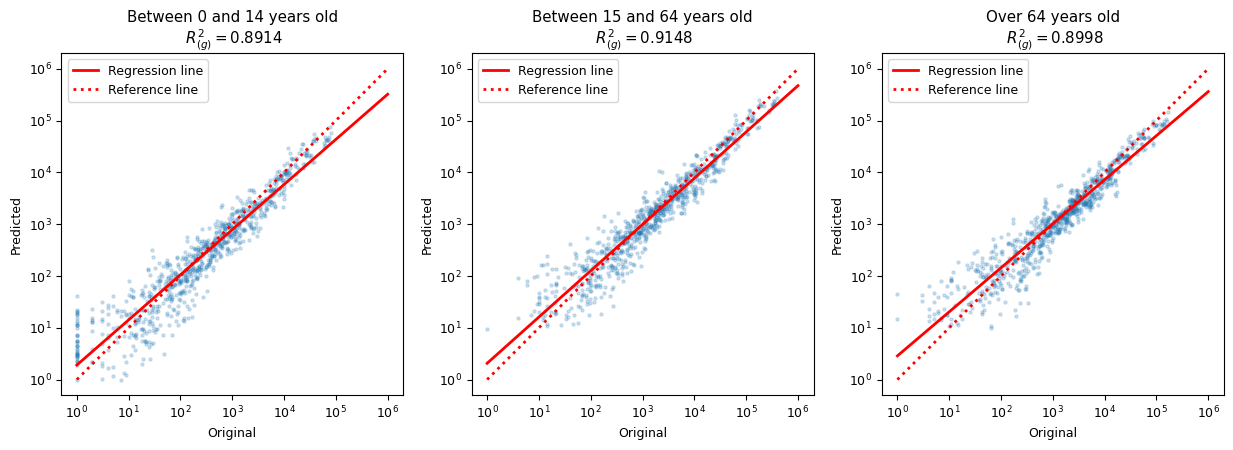

In [17]:
titles = ['Between 0 and 14 years old\n $R^2_{{(g)}}={:.4f}$',
          'Between 15 and 64 years old\n $R^2_{{(g)}}={:.4f}$',
          'Over 64 years old\n $R^2_{{(g)}}={:.4f}$']

titles = [title.format(r2_scores_test[i]) for i, title in enumerate(titles)]

plt.rcParams.update({'font.size': 9})
plt.rc('legend', fontsize=9)

fig, axes = plt.subplots(1,3,figsize=(15,5),sharex=True, sharey=True)

for i,ax in enumerate(axes):
    ax.set_aspect('equal', adjustable='box') 

    ax.scatter(test_labels_logged[:,i], test_outputs[:,i], s=5, alpha=.2)

    coeffs = np.polyfit(test_labels_logged[:, i], test_outputs[:, i], deg=1)
    x_range = np.linspace(0, 6, 100)
    y_range = np.polyval(coeffs, x_range)
    y_reference = np.linspace(0, 6, 100)
    ax.plot(x_range, y_range, color='red', linewidth=2, label= "Regression line")
    ax.plot(x_range, y_reference, color='red', linestyle="dotted", linewidth=2, label="Reference line")

    ax.set_title(titles[i])
    ax.set_xlabel('Original')
    ax.set_ylabel('Predicted')
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set_xticklabels(["$10^{}$".format(i-1) for i in range(8)])
    ax.set_yticklabels(["$10^{}$".format(i-1) for i in range(8)])
    ax.legend()

plt.show()

<div style='text-align: center; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
<b>Figure 12.</b> Prediction performance of trained ResNet50 model by demographic composition groups.
</div>

<h3 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
<i>Generated Dataset for 2022</i>
</h3>

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
The trained CNN model was used for estimating demographic composition in Japan for 2022 as a non-census year. Firstly, mesh cells were employed from those utilised in the training, validation, and testing process. Columns for demographic composition were initialised as zero and year was set as 2022. Totally 4,225 mesh cells were targeted for the dataset generation.
</div>

In [196]:
# collect unique mesh cells
non_census_gdf = master_gdf[['MESH1_ID', 'MESH2_ID', 'KEY_CODE', 'geometry']].drop_duplicates().copy()

# initialise the columns of demographic compositions as zero
non_census_gdf[['0_14', '15_64', 'over_64']] = 0

# initialise the column of year as 2022
non_census_gdf['year'] = 2022

In [191]:
non_census_gdf

MESH1_ID MESH2_ID    KEY_CODE  \
0        6842       00  6842004950   
1        6842       01  6842014950   
2        6842       10  6842104950   
3        4729       35  4729354950   
4        4729       45  4729454950   
...       ...      ...         ...   
6191     4530       51  4530514950   
6861     6442       77  6442774950   
7307     5940       76  5940764950   
7534     5338       11  5338114950   
7575     5338       67  5338674950   

                                               geometry  0_14  15_64  over_65  \
0     POLYGON ((142.00000 45.37500, 142.00000 45.383...     0      0        0   
1     POLYGON ((142.12500 45.37500, 142.12500 45.383...     0      0        0   
2     POLYGON ((142.00000 45.45833, 142.00000 45.466...     0      0        0   
3     POLYGON ((129.62500 31.62500, 129.62500 31.633...     0      0        0   
4     POLYGON ((129.62500 31.70833, 129.62500 31.716...     0      0        0   
...                                                 ...   ...    ...      ...   
6191  POLYGON ((130.12500 30.45833, 130.12500 30.466...     0      0        0   
6861  POLYGON ((142.87500 43.29167, 142.87500 43.300...     0      0        0   
7307  POLYGON ((140.75000 39.95833, 140.75000 39.966...     0      0        0   
7534  POLYGON ((138.12500 35.45833, 138.12500 35.466...     0      0        0   
7575  POLYGON ((138.87500 35.87500, 138.87500 35.883...     0      0        0   

      year  
0     2022  
1     2022  
2     2022  
3     2022  
4     2022  
...    ...  
6191  2022  
6861  2022  
7307  2022  
7534  2022  
7575  2022  

[4225 rows x 8 columns]

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
With the created table "non_census_gdf", an instance of "RemoteSensingDataset" was created and used as an input for "torch.utils.data.DataLoader" object with a batch size of 32 without shuffling. Also, an instance of the CNN model was initialised and its pre-trained parameters were imported from the best model. The pretrained CNN model was used for estimating demographic composition through forward propagation and the outputs were stored in "non_census_outputs". The outputs were concatenated and stored in the initialised columns as original numbers. Moreover, for further visualisation, the ratio of the aged population in mesh cells was calculated, by dividing the number of the population over 64 years old by the total in the mesh cells. The table was then saved as GeoJSON.
</div>

In [192]:
# initialise Dataset and DataLoader
non_census_dataset = RemoteSensingDataset(non_census_gdf)
non_census_loader  = DataLoader(non_census_dataset,  batch_size=32, shuffle=False)

# initialise a CNN model
remote_sensing_cnn = RemoteSensingCNN(out_dim=3, pretrained=True)

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# import the parameters of the best model
remote_sensing_cnn.load_state_dict(torch.load('../src/pretrained/best_model', map_location=torch.device(device)))

# set device
remote_sensing_cnn.to(device)

# set as evaluation mode
remote_sensing_cnn.eval()

# initialise a list to store the output
non_census_outputs = []

# set seed
torch.manual_seed(1)

for i, (img, label) in enumerate(non_census_loader):
    with torch.no_grad():
        # convert images and labels to either CPU tensor or GPU tensor
        img, label = img.to(device), label.to(device)

        # execute forward propagation
        non_census_output = remote_sensing_cnn(img)

        # store the outputs
        non_census_outputs.append(non_census_output.cpu().detach().numpy().copy())

        # clean up the memory
        gc.collect()

# aggregate outputs
non_census_outputs = np.concatenate(non_census_outputs)

# store the original numbers of estimated demographic compositions
non_census_gdf[['0_14', '15_64', 'over_64']] = 10 ** non_census_outputs

# calculate the agining population rate
non_census_gdf['aging_pop_rate'] = 100 * non_census_gdf['over_64'] / non_census_gdf[['0_14', '15_64', 'over_64']].sum(axis=1)

# save the file
non_census_gdf.to_file('../data/census/non_census_gdf.geojson', driver='GeoJSON')

In [131]:
non_census_gdf

MESH1_ID MESH2_ID    KEY_CODE    0_14    15_64  over_64  year  \
0        6842       00  6842004950 22.6158 157.4638 148.9093  2022   
1        6842       01  6842014950 24.4707 125.8835  91.6684  2022   
2        6842       10  6842104950  1.0000  10.6109  16.4361  2022   
3        4729       35  4729354950 50.0156 259.3936 344.3385  2022   
4        4729       45  4729454950 55.1823 349.4573 486.5774  2022   
...       ...      ...         ...     ...      ...      ...   ...   
4220     4530       51  4530514950  5.2601  48.0287  72.1833  2022   
4221     6442       77  6442774950  3.0777  20.6058  13.9328  2022   
4222     5940       76  5940764950  2.4714  25.9159  21.0559  2022   
4223     5338       11  5338114950 44.5895 295.3474 266.7152  2022   
4224     5338       67  5338674950  8.2738  52.7282  69.0000  2022   

      aging_pop_rate                                           geometry  
0            45.2627  POLYGON ((142.00000 45.37500, 142.00000 45.383...  
1            37.8760  POLYGON ((142.12500 45.37500, 142.12500 45.383...  
2            58.6020  POLYGON ((142.00000 45.45833, 142.00000 45.466...  
3            52.6715  POLYGON ((129.62500 31.62500, 129.62500 31.633...  
4            54.5970  POLYGON ((129.62500 31.70833, 129.62500 31.716...  
...              ...                                                ...  
4220         57.5294  POLYGON ((130.12500 30.45833, 130.12500 30.466...  
4221         37.0392  POLYGON ((142.87500 43.29167, 142.87500 43.300...  
4222         42.5860  POLYGON ((140.75000 39.95833, 140.75000 39.966...  
4223         43.9651  POLYGON ((138.12500 35.45833, 138.12500 35.466...  
4224         53.0761  POLYGON ((138.87500 35.87500, 138.87500 35.883...  

[4225 rows x 9 columns]

In [49]:
# read the file
non_census_gdf = gpd.read_file('../data/census/non_census_gdf.geojson')

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Using the estimated demographic composition, a choropleth of the ratio of estimated aged population was visualised in Figure 13. The colour was binned with deciles. As seen in Figure 13, the estimation of aged population rate implied that the urbanised area around Tokyo, Osaka, and Nagoya enjoyed the prosperity of abundant labour force with children, while the others tended to suffer from the deficit of young population.
</div>

In [77]:
centroid = non_census_gdf.unary_union.centroid

m = folium.Map(
    tiles='cartodbpositron',
    location=[centroid.bounds[1], centroid.bounds[0]],
    zoom_start=5)

cp = folium.Choropleth(geo_data='../data/census/non_census_gdf.geojson',
                       name = 'Aged population rate',
                       data = non_census_gdf,
                       columns=['KEY_CODE', 'aging_pop_rate'],
                       key_on="feature.properties.KEY_CODE",
                       fill_opacity=0.8, 
                       line_opacity=0,
                       fill_color='BuPu',
                       legend_name="Ratio of population over 64 years old (%)",
                       bins=[i * 10 for i in range(11)],
                      ).add_to(m)

folium.GeoJsonTooltip(fields=['year', 'aging_pop_rate', '0_14', '15_64', 'over_64'],
                      aliases=['Year', 'Ratio of population over 64 years old (%)', 'Population between 0 and 14 years old', 'Population between 15 and 64 years old', 'Population over 64 years old']).add_to(cp.geojson)


folium.LayerControl().add_to(m)

m

<div style='text-align: center; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
<b>Figure 13.</b> Estimated rate of aged population in Japan as of 2022. The map is based on OpenStreetMap.
</div>

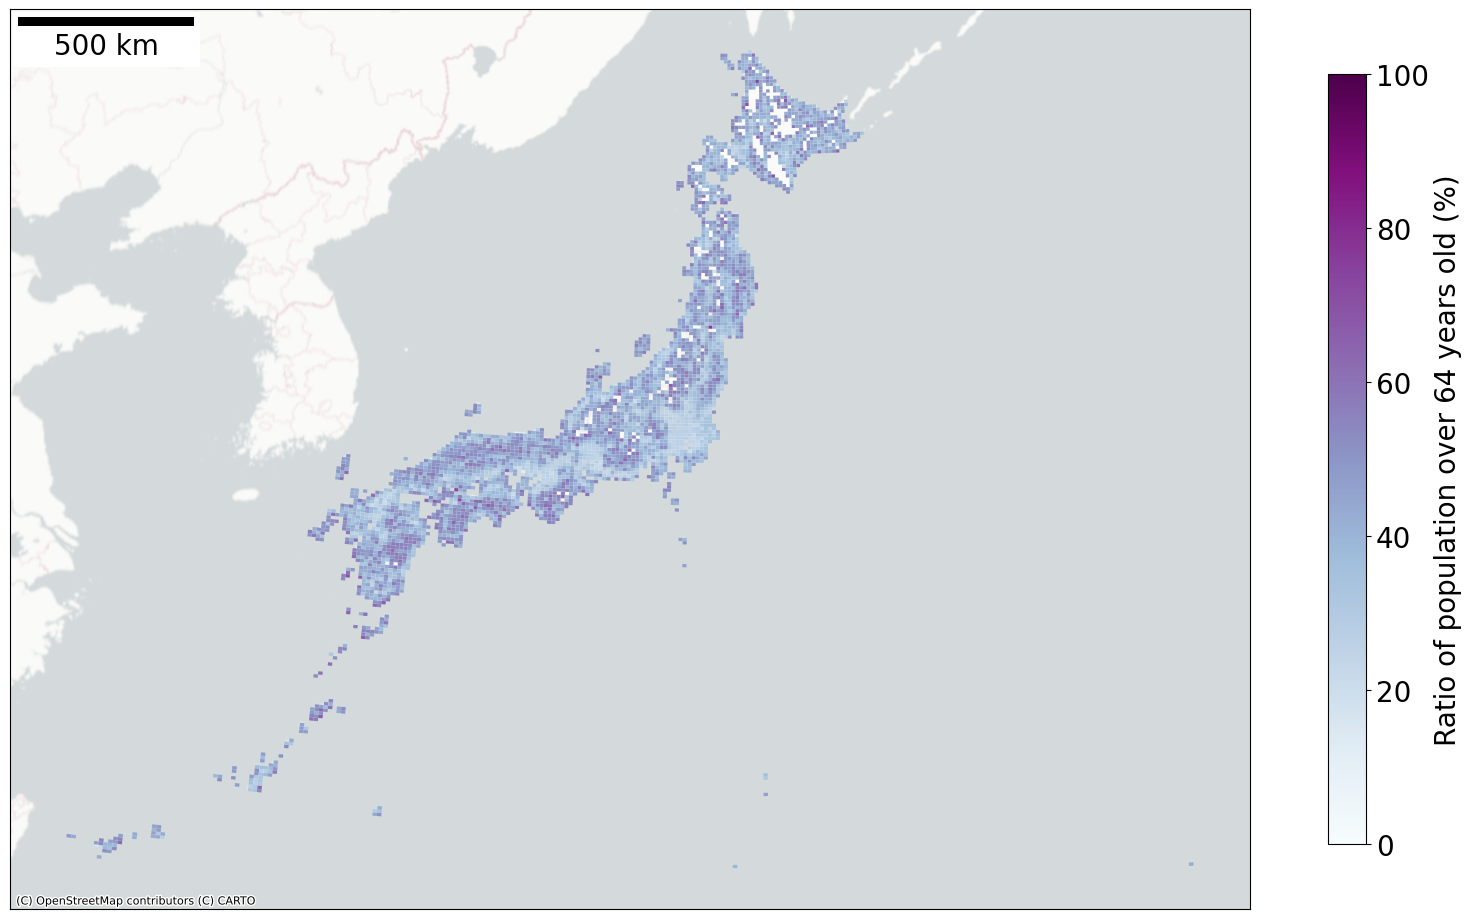

In [24]:
non_census_gdf = non_census_gdf.to_crs(6691)

fig, ax = plt.subplots(1,1,figsize=(20,20))

non_census_gdf.plot(column='aging_pop_rate',
                    legend=True,
                    cmap='BuPu',
                    vmin = 0,
                    vmax = 100,
                    #scheme="User_Defined",
                    #classification_kwds=dict(bins=[i * 10 for i in range(11)]),
                    legend_kwds={
                        "label": "Ratio of population over 64 years old (%)",
                        "shrink":0.5},
                    alpha=1,
                    ax=ax)

ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=non_census_gdf.crs, zoom=5)

ax.add_artist(ScaleBar(
    dx=1,
    location="upper left"))

ax.arrow(0, 0, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow

plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=18)

<h2 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
6. Discussion
</h2>

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
As population aging is in progress among an increasing number of countries and regions, prompt understanding of demographic composition is of urgent importance. This paper demonstrated the mesh-wise estimation of demographic composition in Japan as one of the countries with the most aged society in the world, from the dataset of population census in 2015 and 2020 as labels and satellite images of Landsat-8/OLI and Suomi NPP/VIIRS-DNS. The chosen ResNet50-based CNN model after the training and validation process was tested by the testing dataset with metrics of $R^2_{(g)}$ between original and estimated values for each of the demographic composition groups $g$. In the end, the trained model was used for estimating the demographic composition of Japan in 2022 as a non-census year, and the aged population rate was visualised. The result showed a remarkable test score of $R^2_{(g)}$ with at least 0.8914 for all the demographic composition groups $g$, indicating three contributions of following; Firstly, the result displays the effective usage of pre-trained ResNet50 (He et al., 2016) from the ImageNet dataset consisting of more than 1.2 million images as a 1,000-objects classification task for the demographic composition estimation task with only 6,724 training samples. This result corresponds to previous studies (i.e. Huang et al., 2021) in the sense that the remote sensing tasks share a similar domain with the ImageNet object classification task as image recognition. Secondly, this paper proposes the feasibility of estimating demographic composition rather than total population from satellite images, so that the progress of population aging could be observed without conducting formal surveys such as census. As the values of the loss function both for the validation and testing dataset were not deviated from around 0.32, it is reasonable to confirm that the model held generalisability enough to estimate other geographical locations which were not included in this dataset. Lastly, the proposed CNN model only employed publicly available satellite images as inputs for enduring generalisability in any other geographic location. Since Landsat-8/OLI and Suomi NPP/VIIRS-DNS cover the surface of the earth holistically and periodically, the trained CNN model could be further utilised in other countries in any year. Considering the performance and data availability, the proposed model could help fulfilling the gap between census years not only in Japan but also the other countries and regions for the purposes of urban planning policymaking, especially where rigorous population surveys are limited due to a lack of financial and human resources. 
</div>

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
However, there are certain limitations in the proposed CNN model when it comes to enduring generalisability for further usage. First and foremost, biases in the dataset could result in overfitting in other datasets out of this paper. In terms of the spatial biases stemming from the dataset, the proposed CNN model was trained only by the satellite images in the realm of the population census held by the Japanese government. Since this paper did not conduct testing by a dataset from other countries and regions, the generalisability of the trained CNN model is still uncertain if the condition of morphological landscape in satellite images is different from the one in Japan. To consider the temporal biases in the proposed CNN model, the dataset was obtained from the years 2015 and 2020, where each sample was independently treated and did not explicitly consider the temporal relationship in the same geographical location. Also, the satellite images were pre-processed by annually averaging pixel values from those without clouds, which lacked temporal transition within a sample year. From the model architecture point of view, one way to enhance the proposed CNN model for overcoming these problems is to implement spatio-temporal CNN with the introduction of Long Short-Term Memory (LSTM) blocks (Yu et al., 2022) or Attention mechanism (Yang et al., 2022). Moreover, rather simply and naturally, data argumentation by expanding the geographical locations and sample years could improve the proposed CNN model. Another limitation is the precision of the proposed CNN model. Although the test score reached 0.8914 for the $R^2_{(g)}$ of all the demographic composition groups $g$ in the testing dataset, Figure 12 indicates “heteroscedasty” in the correlation between the original and estimated values. In particular, samples with small population tended to be overestimated with poor precision and higher variance than the others. This could be due to the spatial resolution of the satellite images in the input, where 30m for Landasat-8/OLI and 750m for Suomi NPP/VIIRS-DNS were not granular enough to detect the shape of individual buildings in the extent. Not surprisingly, replacement of Landasat-8/OLI and Suomi NPP/VIIRS-DNS with finer satellite images and stacking of other data sources like spatially interpolated POI data would solve this problem. However, this approach would limit the data availability for geographical locations where the data source cannot be obtained. One potential method without employing new data sources is to synthesise satellite images with finer spatial resolution using Generative Adversarial Network (GAN) for super-resolution (Kong et al., 2023). In future studies, the proposed CNN model could be applied to the other countries and regions with super-resolution to enhance the generalisability and precision for further trustworthy estimation.
</div>

<h2 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
7. Conclusion
</h2>

<div style='text-align: justify; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
This paper proposed a multi-head CNN model based on pretrained ResNet50 to estimate demographic composition in Japan as one of the most aged societies from the dataset of satellite images Landsat-8/OLI as daytime and Suomi NPP/VIIRS-DNS as night-time in the year 2015 and 2020. The trained model showed at least 0.8914 in $R^2_{(g)}$ for all the demographic composition groups $g$ of people below 14 years old, between 15 and 64 years old, and over 64 years old in the testing dataset. The trained model estimated the demographic composition in 2022 as a fulfilment ofa dataset in one of the non-census years of Japan. Since the proposed CNN model requires inputs only from publicly available satellite images at any location on the earth, it holds generalisability to other countries and regions in terms of data availability. Although further studies are expected for evaluating the performance in different geographical locations and enhancing the coarse spatial resolution in the inputs, this paper shall contribute to policymaking for solving problems amongst population aging without conducting q rigorous population survey such as a census
</div>

<h2 style='text-align: justify; font-family: "Times New Roman"; max-width: 1024px;'>
8. References
</h2>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Alley, D., Liebig, P., Pynoos, J., Banerjee, T., &amp; Choi, I. H. (2007). Creating elder-friendly communities. Journal of Gerontological Social Work, 49(1–2), 1–18. https://doi.org/10.1300/j083v49n01_01 
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
AWS. (2023). Amazon EC2 G4 Instances. Amazon.com. https://aws.amazon.com/ec2/instance-types/g4/ 
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Bagan, H., & Yamagata, Y. (2015). Analysis of urban growth and estimating population density using satellite images of nighttime lights and land-use and population data. GIScience &amp; Remote Sensing, 52(6), 765–780. https://doi.org/10.1080/15481603.2015.1072400
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Barentine, J. C., Walczak, K., Gyuk, G., Tarr, C., & Longcore, T. (2021). A case for a new satellite mission for remote sensing of Night Lights. Remote Sensing, 13(12), 2294. https://doi.org/10.3390/rs13122294
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Bongaarts, J. (2004). Population aging and the rising cost of public pensions. Population and Development Review, 30(1), 1–23. https://doi.org/10.1111/j.1728-4457.2004.00001.x
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Campos-Taberner, M., García-Haro, F. J., Martínez, B., Izquierdo-Verdiguier, E., Atzberger, C., Camps-Valls, G., &amp; Gilabert, M. A. (2020). Understanding deep learning in land use classification based on Sentinel-2 time series. Scientific Reports, 10(1). https://doi.org/10.1038/s41598-020-74215-5
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Cheng, L., Wang, L., Feng, R., &amp; Yan, J. (2021). Remote Sensing and Social Sensing Data Fusion for Fine-Resolution Population Mapping With a Multimodel Neural Network. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 14, 5973–5987. https://doi.org/10.1109/jstars.2021.3086139
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
de Bem, P., de Carvalho Junior, O., Fontes Guimarães, R., &amp; Trancoso Gomes, R. (2020). Change detection of deforestation in the Brazilian amazon using landsat data and Convolutional Neural Networks. Remote Sensing, 12(6), 901. https://doi.org/10.3390/rs12060901
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Deng, L. (2014). A tutorial survey of Architectures, algorithms, and applications for Deep Learning. APSIPA Transactions on Signal and Information Processing, 3(1). https://doi.org/10.1017/atsip.2013.9
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
e-Stat. (2023). Population census. Portal Site of Official Statistics of Japan. https://www.e-stat.go.jp/en/stat-search?page=1&amp;toukei=00200521&amp;toukei_kind=6&amp;metadata=1&amp;data=1
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Earth Observation Group. (2023). See the world at night. VIIRS Nighttime Light. https://eogdata.mines.edu/products/vnl/
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Elvidge, C., Zhizhin, M., Hsu, F.-C., &amp; Baugh, K. (2013). VIIRS Nightfire: Satellite Pyrometry at Night. Remote Sensing, 5(9), 4423–4449. https://doi.org/10.3390/rs5094423 
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Elvidge, C. D., Zhizhin, M., Ghosh, T., Hsu, F.-C., &amp; Taneja, J. (2021). Annual time series of global VIIRS Nighttime Lights derived from monthly averages: 2012 to 2019. Remote Sensing, 13(5), 922. https://doi.org/10.3390/rs13050922
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
ESA. (2023). Sentinel Overview. Sentinel Online. https://sentinel.esa.int/web/sentinel/missions
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Feldhoff, T. (2012). Shrinking communities in Japan: Community ownership of assets as a development potential for rural Japan? URBAN DESIGN International, 18(1), 99–109. https://doi.org/10.1057/udi.2012.26
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Gillies, S. (2023). rasterio Documentation. Read the Docs. https://buildmedia.readthedocs.org/media/pdf/rasterio/stable/rasterio.pdf
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Google. (2023). USGS landsat 8 level 2, Collection 2, tier 1. Earth Engine Data catalog. https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
He, K., Zhang, X., Ren, S., &amp; Sun, J. (2016). Deep residual learning for image recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2016.90
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Henderson, J. V., Storeygard, A., &amp; Weil, D. N. (2012). Measuring economic growth from Outer Space. American Economic Review, 102(2), 994–1028. https://doi.org/10.1257/aer.102.2.994</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Henderson, M., Yeh, E. T., Gong, P., Elvidge, C., & Baugh, K. (2003). Validation of urban boundaries derived from Global Night-time satellite imagery. International Journal of Remote Sensing, 24(3), 595–609. https://doi.org/10.1080/01431160304982
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Hu, W., Patel, J. H., Robert, Z.-A., Novosad, P., Asher, S., Tang, Z., Burke, M., Lobell, D., &amp; Ermon, S. (2019). Mapping Missing Population in Rural India: A Deep Learning Approach with Satellite Imagery. Proceedings of the 2019 AAAI/ACM Conference on AI, Ethics, and Society. https://doi.org/10.1145/3306618.3314263</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Huang, X., Zhu, D., Zhang, F., Liu, T., Li, X., &amp; Zou, L. (2021). Sensing population distribution from satellite imagery via Deep Learning:model selection, neighboring effects, and systematic biases. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 14, 5137–5151. https://doi.org/10.1109/jstars.2021.3076630</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Ioffe, S., &amp; Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv.org. https://arxiv.org/abs/1502.03167</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Jenice, A. R., &amp; Raimond, K. (2016). An overview of technological revolution in satellite image analysis. Journal of Engineering Science and Technology Review, 9(4), 1–5. https://doi.org/10.25103/jestr.094.01</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Jordahl, K., Bossche, J. V. den, Fleischmann, M., Wasserman, J., McBride, J., Gerard, J., Tratner, J., Perry, M., Badaracco, A. G., Farmer, C., Hjelle, G. A., Snow, A. D., Cochran, M., Gillies, S., Culbertson, L., Bartos, M., Eubank, N., Maxalbert, Bilogur, A., … Leblanc, F. (2020). Geopandas/geopandas: V0.8.1. Zenodo. https://doi.org/10.5281/zenodo.3946761</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Kaplan, G., Avdan, U., &amp; Avdan, Z. Y. (2018). Urban heat island analysis using the landsat 8 satellite data: A case study in Skopje, Macedonia. The 2nd International Electronic Conference on Remote Sensing, 2(7), 358. https://doi.org/10.3390/ecrs-2-05171</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Kaufman, S., Rosset, S., &amp; Perlich, C. (2011). Leakage in Data Mining. ACM Transactions on Knowledge Discovery from Data, 6(4), 1–21. https://doi.org/10.1145/2382577.2382579</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Kertzer, D. I., White, M. J., Bernardi, L., &amp; Gabrielli, G. (2009). Italy’s path to very low fertility: The adequacy of economic and second demographic transition theories. European Journal of Population / Revue Européenne de Démographie, 25(1), 89–115. https://doi.org/10.1007/s10680-008-9159-5</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Kingma, D. P., &amp; Ba, J. (2017). Adam: A method for stochastic optimization. arXiv.org. https://arxiv.org/abs/1412.6980</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Kong, J., Ryu, Y., Jeong, S., Zhong, Z., Choi, W., Kim, J., Lee, K., Lim, J., Jang, K., Chun, J., Kim, K.-M., &amp; Houborg, R. (2023). Super resolution of historic landsat imagery using a dual generative Adversarial Network (GAN) model with CubeSat constellation imagery for spatially enhanced long-term vegetation monitoring. ISPRS Journal of Photogrammetry and Remote Sensing, 200, 1–23. https://doi.org/10.1016/j.isprsjprs.2023.04.013
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Krizhevsky, A., Sutskever, I., &amp; Hinton, G. E. (2017). ImageNet classification with deep convolutional Neural Networks. Communications of the ACM, 60(6), 84–90. https://doi.org/10.1145/3065386</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Li, X., Chen, S., Hu, X., &amp; Yang, J. (2019). Understanding the disharmony between dropout and batch normalization by variance shift. 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2019.00279</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Mellander, C., Lobo, J., Stolarick, K., & Matheson, Z. (2015). Night-time Light Data: A good proxy measure for economic activity? PLoS One, 10(10). https://doi.org/10.1371/journal.pone.0139779
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Ministry of Land, Infrastructure, Transport and Tourism. (2020). 国土交通白書 2020. 2　東京一極集中と地方への影響. https://www.mlit.go.jp/hakusyo/mlit/r01/hakusho/r02/html/n1112000.html</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Nakatani, H. (2019). Population aging in Japan: Policy transformation, sustainable development goals, Universal Health Coverage, and social determinates of health. Global Health &amp;amp; Medicine, 1(1), 3–10. https://doi.org/10.35772/ghm.2019.01011</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
NOAA. (2023). Suomi NPP Visible Infrared Imaging Radiometer Suite (VIIRS). NOAA National Calibration Center. https://ncc.nesdis.noaa.gov/VIIRS/</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Office for National Statistics. (2023). Census. Office for National Statistics. https://www.ons.gov.uk/census</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Köpf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Fang, L., … Chintala, S. (2019). Pytorch: An imperative style, high-performance deep learning library. arXiv.org. https://arxiv.org/abs/1912.01703</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., &amp; Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. The Journal of Machine Learning Research, 12, 2825–2830. https://doi.org/https://dl.acm.org/doi/10.5555/1953048.2078195</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Phiri, D., Simwanda, M., Salekin, S., Nyirenda, V., Murayama, Y., &amp; Ranagalage, M. (2020). Sentinel-2 data for land cover/use mapping: A Review. Remote Sensing, 12(14), 2291. https://doi.org/10.3390/rs12142291</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Rumelhart, D. E., Hinton, G. E., &amp; Williams, R. J. (1986). Learning representations by back-propagating errors. Nature, 323(6088), 533–536. https://doi.org/10.1038/323533a0</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M., Berg, A. C., &amp; Fei-Fei, L. (2015). Imagenet Large Scale Visual Recognition Challenge. International Journal of Computer Vision, 115(3), 211–252. https://doi.org/10.1007/s11263-015-0816-y</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Shin, H.-C., Roth, H. R., Gao, M., Lu, L., Xu, Z., Nogues, I., Yao, J., Mollura, D., &amp; Summers, R. M. (2016). Deep convolutional neural networks for computer-aided detection: CNN Architectures, dataset characteristics and transfer learning. IEEE Transactions on Medical Imaging, 35(5), 1285–1298. https://doi.org/10.1109/tmi.2016.2528162</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Simonyan, K., &amp; Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. arXiv.org. https://arxiv.org/abs/1409.1556</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Solórzano, J. V., Mas, J. F., Gao, Y., &amp; Gallardo-Cruz, J. A. (2021). Land use land cover classification with U-Net: Advantages of combining sentinel-1 and sentinel-2 imagery. Remote Sensing, 13(18), 3600. https://doi.org/10.3390/rs13183600</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Song, J., Tong, X., Wang, L., Zhao, C., &amp; Prishchepov, A. V. (2019). Monitoring finer-scale population density in urban functional zones: A remote sensing data fusion approach. Landscape and Urban Planning, 190, 103580. https://doi.org/10.1016/j.landurbplan.2019.05.011</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Statistics Bureau of Japan. (2023a). Method of Demarcation for Grid Square. Statistics Bureau Home Page. https://www.stat.go.jp/english/data/mesh/05.html</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Statistics Bureau of Japan. (2023b). population census. Statistics Bureau home page. https://www.stat.go.jp/english/data/kokusei/index.html</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Szegedy, C., Wei Liu, Yangqing Jia, Sermanet, P., Reed, S., Anguelov, D., Erhan, D., Vanhoucke, V., &amp; Rabinovich, A. (2015). Going deeper with convolutions. 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 1–9. https://doi.org/10.1109/cvpr.2015.7298594</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Ulmas, P., &amp; Liiv, I. (2020). Segmentation of satellite imagery using U-net models for land cover classification. arXiv.org. https://arxiv.org/abs/2003.02899</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
US Census Bureau. (2022). Decennial census of population and housing by decades. Census.gov. https://www.census.gov/programs-surveys/decennial-census/decade.html</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
USGS. (2018). USGS eros archive - landsat archives - landsat 8 oli (operational land imager) and TIRS (thermal infrared sensor) level-1 Data Products Active. USGS.gov. https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-oli-operational-land-imager-and</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
USGS. (2023). Landsat missions. USGS.gov. https://www.usgs.gov/landsat-missions</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Wang, Y., Huang, C., Zhao, M., Hou, J., Zhang, Y., &amp; Gu, J. (2020). Mapping the population density in mainland China using NPP/viirs and points-of-interest data based on a random forests model. Remote Sensing, 12(21), 3645. https://doi.org/10.3390/rs12213645</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Wasser, L., Joseph, M., McGlinchy, J., Palomino, J., Korinek, N., Holdgraf, C., &amp; Head, T. (2019). EarthPy: A python package that makes it easier to explore and plot raster and vector data using open source python tools. Journal of Open Source Software, 4(43), 1886. https://doi.org/10.21105/joss.01886</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
World Bank. (2023). Population ages 65 and above (% of total population). https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
World Health Organization. (2022). Ageing and health. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/ageing-and-health</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Wu, C., &amp; Murray, A. T. (2007). Population estimation using Landsat Enhanced Thematic Mapper imagery. Geographical Analysis, 39(1), 26–43. https://doi.org/10.1111/j.1538-4632.2006.00694.x</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Yang, G., Yang, Y., Lu, Z., Yang, J., Liu, D., Zhou, C., &amp; Fan, Z. (2022). Sta-TSN: Spatial-temporal attention temporal segment network for action recognition in video. PLOS ONE, 17(3). https://doi.org/10.1371/journal.pone.0265115</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Yang, J., Guo, J., Yue, H., Liu, Z., Hu, H., &amp; Li, K. (2019). CDnet: CNN-based cloud detection for remote sensing imagery. IEEE Transactions on Geoscience and Remote Sensing, 57(8), 6195–6211. https://doi.org/10.1109/tgrs.2019.2904868</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Yu, D., Wang, X., Liang, P., &amp; Sun, X. (2022). Spatio-temporal convolutional residual network for regional commercial vitality prediction. Multimedia Tools and Applications, 81(19), 27923–27948. https://doi.org/10.1007/s11042-022-12845-9
</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Zhuang, F., Qi, Z., Duan, K., Xi, D., Zhu, Y., Zhu, H., Xiong, H., &amp; He, Q. (2021). A comprehensive survey on Transfer Learning. Proceedings of the IEEE, 109(1), 43–76. https://doi.org/10.1109/jproc.2020.3004555</div>

<div style='text-align: left; font-family: "Times New Roman"; font-size: 100%; line-height: 120%; max-width: 1024px;'>
Özelkan, E. (2020). Water body detection analysis using NDWI indices derived from landsat-8 oli. Polish Journal of Environmental Studies, 29(2), 1759–1769. https://doi.org/10.15244/pjoes/110447</div>